In [44]:
%matplotlib inline

import numpy as np
import pylab as pl
import matplotlib.patches as patches
import matplotlib as mpl

In [45]:
class Joint:
    def __init__(self, angle):
        self.prevlink=None
        self.angle=angle
    def add(self, link):
        link.prevjoint = self
        self.nextlink = link
    def getTrafo(self):
        pt = self.prevlink.getTrafo() if self.prevlink else mpl.transforms.Affine2D.identity()
        return mpl.transforms.Affine2D().rotate_deg(self.angle) + pt
    
class Link:
    def __init__(self, length):
        self.length = length
        self.w = .2
        self.prevjoint = None
        self.nextjoint = None
        self.com = None
        self.forces = []
        self.forcepositions = []
        self.forcecolors = "rgbky"
    def add(self, nextjoint):
        self.nextjoint = nextjoint
        nextjoint.prevlink = self
    def getTrafo(self):
        return mpl.transforms.Affine2D().translate(self.length, 0) + self.prevjoint.getTrafo();
    def addCOM(self, x):
        self.com = x
    def draw(self, ax):
        rect = patches.Rectangle((0,0),self.length,self.w,0,facecolor="none")
        ax.add_patch(rect)
        rect.set_transform(self.prevjoint.getTrafo() + ax.transData)
        if self.com:
            comrect = patches.Rectangle((self.com,0),self.w,self.w,0,facecolor="red")
            comrect.set_transform(self.prevjoint.getTrafo() + ax.transData)
            ax.add_patch(comrect)
        for f, pos, i in zip(self.forces, self.forcepositions, range(len(self.forces))):
            arrow = patches.Arrow(pos, 0, f[0], f[1], width=0.5, color=self.forcecolors[i])
            arrow.set_transform(self.prevjoint.getTrafo() + ax.transData)
            ax.add_patch(arrow)
    def addForce(self, pos, f): # add force in world coordinates
        self.forces.append(np.dot(self.prevjoint.getTrafo().inverted(), f))
        self.forcepositions.append(pos)
        #print self.forces[-1]
        
        
        

        
        

In [46]:
def intersect(base1, dir1, base2, dir2):
    d = np.array((dir1, dir2)).T
    t = np.dot(np.linalg.inv(d),base2-base1)
    #print d
    #print np.linalg.inv(d)
    #print t
    #base1 + t[0] * dir1
    #print base2 - t[1] * dir2
    return base1 + t[0] * dir1
    

In [47]:

    
intersect(np.array([1,1]), np.array([1,0]), np.array([2,0]), np.array([0,1]))

b1 = np.array([-2,-1])
d1 = np.array([-1,0.7])
b2 = np.array([4,0])
d2 = np.array([-0.6,0.3])

i = intersect(b1, d1, b2, d2);

#pl.plot([b1[0], b1[0]+d1[0]], [b1[1], b1[1]+d1[1]])
#pl.plot([b2[0], b2[0]+d2[0]], [b2[1], b2[1]+d2[1]])
#pl.scatter(i[0], i[1])

#pl.plot()

In [48]:
def topbarforces(xg, x1, x2, fg, d2):
    pg = np.array([xg,0])
    p1 = np.array([x1, 0])
    p2= np.array([x2,0])
    i = intersect(pg, fg, p2, d2)
    d1 = i - p1
    i2 = intersect(pg, d1, pg+fg, d2)
    f2 = i2-(pg+fg)
    f1 = pg-i2
    return f1, f2, i, i2


[-65.  70.]


(-200, 200, -200, 200)

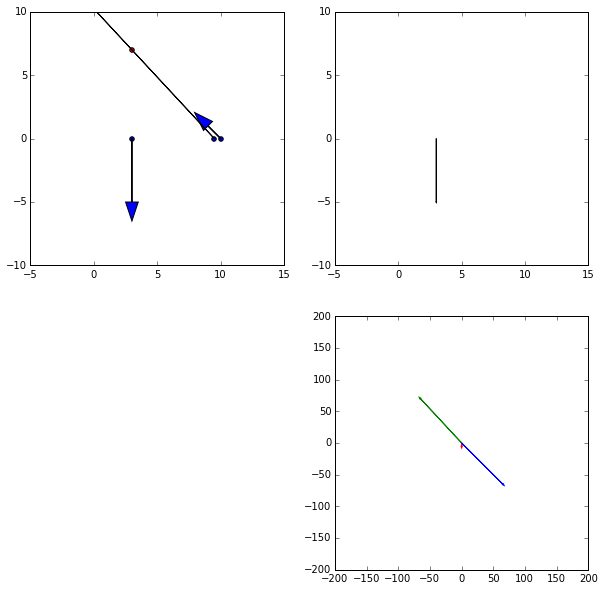

In [49]:



xg = 3
x1 = 9.5
x2 = 10
fg = np.array([0,-5])
d2 = np.array([-1, 1])
f1, f2, i, i2 = topbarforces(xg, x1, x2, fg, d2)
    
pl.figure(figsize=(10,10))
pl.subplot(221)

pl.arrow(xg, 0, fg[0], fg[1], width=0.05)
pl.arrow(x2, 0, d2[0], d2[1], width=0.05)
pl.scatter([xg, x1, x2], [0,0,0])
pl.scatter(i[0], i[1], c="r")
print f1
pl.arrow(x1, 0, f1[0], f1[1])

pl.axis((-5, 15, -10, 10))

pl.subplot(222)

pl.axis((-5, 15, -10, 10))
pl.arrow(xg, 0, fg[0], fg[1])
pl.scatter(i2[0], i2[1])

pl.subplot(224)
pl.arrow(0, 0, fg[0], fg[1], color="r", width=.1)
pl.arrow(0, 0, f1[0], f1[1], color="g", width=.1)
pl.arrow(0, 0, f2[0], f2[1], color="b", width=.1)
pl.axis((-200,200,-200,200))

In [50]:
def v3(v):
    vv = np.zeros((3,))
    vv[:2] = v
    return vv

def torques(phi2, phi3, l2, l3, lt, xg, fg ):
    xg = xg + l3
    
    A2 = Joint(angle=phi2)
    A3 = Joint(angle=phi3)
    L2 = Link(l2)
    L3 = Link(l3)
    A2.add(L2)
    A3.add(L3)
    PA3b = Joint(angle=phi2-phi3)
    L3.add(PA3b)
    Lb = Link(l2)
    PA3b.add(Lb)
    Pbt = Joint(angle=180-(phi2-phi3))
    Lb.add(Pbt)
    Lt=Link(lt)
    Pbt.add(Lt)
    x1=l3
    x2=0
    Lt.addCOM(xg)
    # top bar foreces in top bar CS?
    fg = v3(fg)
    fgt = np.dot(Lt.getTrafo().inverted(), fg)
    d2 = np.dot(Lb.getTrafo(), np.array([1,0,0]))
    d2t= np.dot(Lt.getTrafo().inverted(), d2)
    fat, fbt, _, __ = topbarforces(xg, x1, x2, fgt[:2], d2t[:2])
    fa = np.dot(Lt.getTrafo(), v3(fat))
    fb = np.dot(Lt.getTrafo(), v3(fbt))
    # kraft die unten an L3 angreift
    f3 = -fb
    # kraft am hebel L2
    f2 = -fa
    p0 = np.array([0,0]) # where the axes are
    pt2 = np.dot(L2.getTrafo(), np.array([l2,0,0]))[:2] # tip of L2
    pt3 = np.dot(L3.getTrafo(), np.array([l3,0,0]))[:2] # tip of L3
    TA2 = np.dot(np.array([0,0,1]), np.cross(pt2-p0, f2))
    TA3 = np.dot(np.array([0,0,1]), np.cross(pt3-p0, f3))
    pg = np.dot(Lt.prevjoint.getTrafo(), np.array([xg, 0, 1])) # center of gravity ni world coordinates
    TA2n = np.dot(np.array([0,0,1]), np.cross(pg-v3(p0), fg))
    TA3n = np.dot(np.array([0,0,1]), np.cross(pg-v3(pt2), fg))
    return TA2, TA3, TA2n, TA3n

torques(90, 0, 15, 5, 12, 8, [0,-6])

(1.231698504097973e-14, -107.99999999999997, 47.999999999999993, 48.0)

Torques: 
TA2 = 25
TA3 = 9.39693
Naive torques:
TA2n = 34.3969
TA3n = 9.39693
(24.999999999999979, 28.190778623577252, 53.190778623577245, 28.190778623577259)


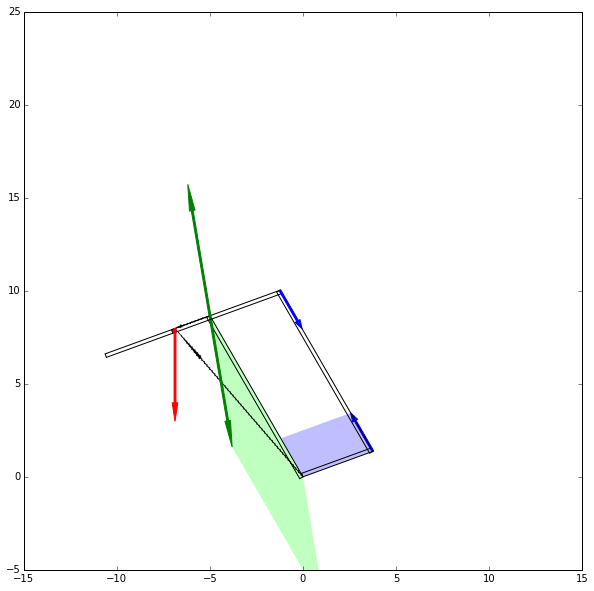

In [68]:


   

phi2 = 120
phi3 = 20

A2 = Joint(angle=phi2)
A3 = Joint(angle=phi3)

l2=10
l3=4
lt=10

L2 = Link(l2)
L3 = Link(l3)
A2.add(L2)
A3.add(L3)
PA3b = Joint(angle=phi2-phi3)
L3.add(PA3b)
Lb = Link(l2)
PA3b.add(Lb)
Pbt = Joint(angle=180-(phi2-phi3))
Lb.add(Pbt)
Lt=Link(lt)
Pbt.add(Lt)

xg=l3+2
x1=l3
x2=0

Lt.addCOM(xg)

# top bar foreces in top bar CS?
fg =  np.array([0, -5, 0])
fgt = np.dot(Lt.getTrafo().inverted(), fg)
d2 = np.dot(Lb.getTrafo(), np.array([1,0,0]))
d2t= np.dot(Lt.getTrafo().inverted(), d2)
fat, fbt, _, __ = topbarforces(xg, x1, x2, fgt[:2], d2t[:2])

fa = np.dot(Lt.getTrafo(), v3(fat))
fb = np.dot(Lt.getTrafo(), v3(fbt))

Lt.addForce(xg, fg)
Lt.addForce(x1, fa)
Lt.addForce(x2, fb)

# kraft die unten an L3 angreift
f3 = -fb
f2 = -fa

L3.addForce(l3, np.array([0,0,0]))
L3.addForce(l3, np.array([0,0,0])) # just a hackish way to advance the colors
L3.addForce(l3, f3)
L2.addForce(l2, np.array([0,0,0]))
L2.addForce(l2, f2)

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# parallelograms visualizing torque
p0 = np.array([0,0]) # where the axes are
pt2 = np.dot(L2.getTrafo(), np.array([l2,0,0]))[:2] # tip of L2
pt3 = np.dot(L3.getTrafo(), np.array([l3,0,0]))[:2] # tip of L3
ax.add_patch(patches.Polygon(xy=[p0, pt2, pt2+f2[:2], p0+f2[:2]], fill=True, edgecolor='none', facecolor=(0,1,0,0.25)))
ax.add_patch(patches.Polygon(xy=[p0, pt3, pt3+f3[:2], p0+f3[:2]], fill=True, edgecolor='none', facecolor=(0,0,1,0.25)))

TA2 = np.dot(np.array([0,0,1]), np.cross(pt2-p0, f2))
TA3 = np.dot(np.array([0,0,1]), np.cross(pt3-p0, f3))

pg = np.dot(Lt.prevjoint.getTrafo(), np.array([xg, 0, 1])) # center of gravity ni world coordinates

ax.add_patch(patches.Arrow(p0[0], p0[1], pg[0]-p0[0], pg[1]-p0[1], width=0.25, color="k", linestyle='dotted'))
ax.add_patch(patches.Arrow(pt2[0], pt2[1], pg[0]-pt2[0], pg[1]-pt2[1], width=0.25, color="k", linestyle='dotted'))

TA2n = np.dot(np.array([0,0,1]), np.cross(pg-v3(p0), fg))
TA3n = np.dot(np.array([0,0,1]), np.cross(pg-v3(pt2), fg))


print("Torques: ")
print("TA2 = %g" % TA2)
print("TA3 = %g" % TA3)
print("Naive torques:")
print("TA2n = %g" % TA2n)
print("TA3n = %g" % TA3n)

print torques(phi2, phi3, l2, l3, lt, xg, fg[:2])

L2.draw(ax)
L3.draw(ax)
Lb.draw(ax)
Lt.draw(ax)


ax.set_xlim((-15, 15))
ax.set_ylim((-5, 25))
pl.show()

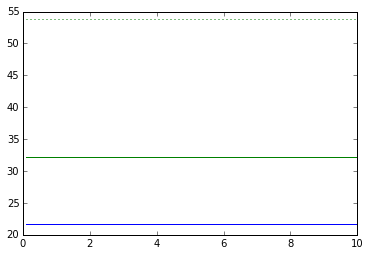

In [52]:
phi2 = 130
phi3 = -30
l2=10
lt=10
xg=5
fg=np.array([0,-5])

l3s=np.linspace(.1, 10,100)
ts = np.array([torques(phi2, phi3, l2, l3, lt, xg, fg) for l3 in l3s])

pl.plot(l3s, ts[:,0], "g")
pl.plot(l3s, ts[:,1], "b")
pl.plot(l3s, ts[:,2], "g:")
pl.plot(l3s, ts[:,3], "b:")


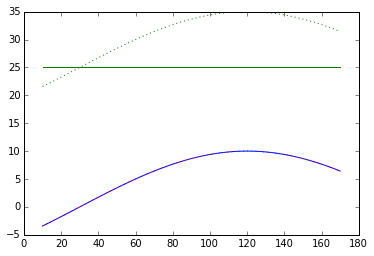

In [66]:
betas = np.linspace(10,170,100)
phi2 = 120
l2=10
l3=4
lt=10
xg=2
fg=np.array([0,-5])
ts = np.array([torques(phi2, phi2-beta, l2, l3, lt, xg, fg) for beta in betas])

pl.plot(betas, ts[:,0], "g")
pl.plot(betas, ts[:,1], "b")
pl.plot(betas, ts[:,2], "g:")
pl.plot(betas, ts[:,3], "r:")

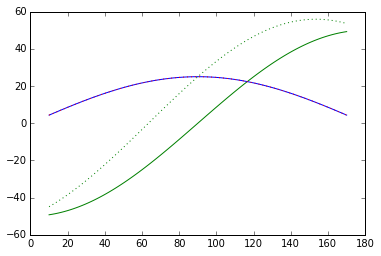

In [56]:
beta = 90
phi2s = np.linspace(10, 170, 100)
l2=10
l3=3
lt=10
xg=5
fg=np.array([0,-5])
ts = np.array([torques(phi2, phi2-beta, l2, l3, lt, xg, fg) for phi2 in phi2s])

pl.plot(betas, ts[:,0], "g")
pl.plot(betas, ts[:,1], "b")
pl.plot(betas, ts[:,2], "g:")
pl.plot(betas, ts[:,3], "r:")